In [2]:
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf
print(tf.__version__)
import gym
import cv2
import random
from collections import deque
import matplotlib.pyplot as plt
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


TensorFlow 1.x selected.
1.15.2


## **Problem 1**: Cartpole-v0
Train a simple neural net that models the policy. Use discount factor = 0.95. Plot (average) episode reward versus training epochs.

Load Environment

In [9]:
env = gym.make("CartPole-v0")

Environment and Training Hyperparameters

In [10]:
# Environment hyperparameters
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
possible_actions = np.identity(action_size,dtype=int).tolist()

# Training hyperparameters
learning_rate = 0.002
num_epochs = 500
batch_size = 1000

training = True

In [3]:
def discount_rewards(r, gamma=0.95, normalization=False):
    "take 1D float array of rewards and compute discounted rewards"
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
  
    if normalization:
        mean = np.mean(discounted_r)
        std = np.std(discounted_r)
        discounted_r = (discounted_r - mean)/std

    return discounted_r

Prepare 4 last processed frames to be fed to Conv net

In [13]:
class PGNetwork:
    def __init__(self, state_size, action_size, learning_rate, name = "PGNetwork"):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate

        with tf.variable_scope(name):
            with tf.name_scope("inputs"):
                self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name = "inputs_")
                self.actions = tf.placeholder(tf.int32, [None, action_size], name = "actions")
                self.discounted_episode_reward_delta = tf.placeholder(tf.float32, [None, ], name = "discounted_episode_reward_delta")

            with tf.name_scope("fc1"):
                self.fc = tf.layers.dense(inputs = self.inputs_,
                                          units = 512,
                                          activation = tf.nn.relu,
                                          kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                          name = "fc1")

            with tf.name_scope("logits"):
                self.logits = tf.layers.dense(inputs = self.fc,
                                          units = action_size,
                                          activation = None,
                                          kernel_initializer = tf.contrib.layers.xavier_initializer())

            with tf.name_scope("softmax"):
                self.action_distribution = tf.nn.softmax(self.logits)

            with tf.name_scope("loss"):
                self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.actions)
                self.weighted_negative_likelihoods = tf.multiply(self.cross_entropy, self.discounted_episode_reward_delta)
                self.loss = tf.reduce_mean(self.weighted_negative_likelihoods)

            with tf.name_scope("train"):
                self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
                self.train_opt = self.optimizer.minimize(self.loss)


In [14]:
class ValueEstimator:
    def __init__(self, state_size, learning_rate, name = "ValueEstimator"):
        self.state_size = state_size
        self.learning_rate = learning_rate

        with tf.variable_scope(name):
            with tf.name_scope("inputs"):
                self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name = "inputs_")
                self.discounted_episode_rewards_ = tf.placeholder(tf.float32, [None, ], name = "discounted_episode_rewards_")

            with tf.name_scope("fc1"):
                self.fc = tf.layers.dense(inputs = self.inputs_,
                                          units = 512,
                                          activation = tf.nn.relu,
                                          kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                          name = "fc1")
            with tf.name_scope("logits"):
                self.output = tf.layers.dense(inputs = self.fc,
                                        units = 1,
                                        activation = None,
                                        kernel_initializer = tf.contrib.layers.xavier_initializer())

            with tf.name_scope("output"):
                self.state_value_estimation = tf.squeeze(self.output)

            with tf.name_scope("loss"):
                self.loss = tf.reduce_mean(tf.squared_difference(self.state_value_estimation, self.discounted_episode_rewards_))

            with tf.name_scope("train"):
                self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
                self.train_opt = self.optimizer.minimize(self.loss)


In [ ]:
def make_batch(batch_size):
    states, episode_states, actions, rewards_of_episode, rewards_of_batch, discounted_rewards, discounted_reward_delta = [],[],[],[],[],[],[]

    episode_num = 1

    state = env.reset()
    while True:
        action_probability_distribution = sess.run(PGNetwork.action_distribution, feed_dict = {PGNetwork.inputs_:state.reshape(1, state_size)}) 
        action = np.random.choice(range(action_probability_distribution.shape[1]), p = action_probability_distribution.ravel())

        next_step, reward, done, info = env.step(action)

        states.append(state)
        episode_states.append(state)
        action_ = [1 if i==action else 0 for i in range(action_size)]
        actions.append(action_)
        rewards_of_episode.append(reward)

        if done:
            rewards_of_batch.append(rewards_of_episode)
            discounted_rewards_of_episode = discount_rewards(rewards_of_episode, normalization = False)
            discounted_rewards.append(discounted_rewards_of_episode)

            value_est = sess.run(ValueEstimator.state_value_estimation, feed_dict={ValueEstimator.inputs_:np.stack(episode_states).reshape((len(episode_states), state_size))})
            discounted_reward_delta.append(discounted_rewards_of_episode - value_est)

            if len(np.concatenate(rewards_of_batch)) > batch_size:
                break

            rewards_of_episode = []
            episode_states = []
            episode_num += 1
            state = env.reset()
        else:
            state = next_step


    return np.stack(np.array(states)), np.stack(np.array(actions)), np.concatenate(rewards_of_batch), np.concatenate(discounted_rewards), np.concatenate(discounted_reward_delta), episode_num





In [ ]:
tf.reset_default_graph()
PGNetwork = PGNetwork(state_size, action_size, learning_rate)
ValueEstimator = ValueEstimator(state_size, learning_rate)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [ ]:
allRewards = []

maximumRewardRecorded = 0
mean_reward_total = []
epoch = 1
average_reward = []

saver = tf.train.Saver()


if training:
    while epoch < num_epochs + 1:
        states_mb, actions_mb, rewards_of_batch, discounted_rewards_mb, discounted_reward_delta_mb, nb_episodes_mb = make_batch(batch_size)
        total_reward_of_that_batch = np.sum(rewards_of_batch)
        allRewards.append(total_reward_of_that_batch)

        mean_reward_of_that_batch = np.divide(total_reward_of_that_batch, nb_episodes_mb)
        mean_reward_total.append(mean_reward_of_that_batch)

        average_reward_of_all_training = np.divide(np.sum(mean_reward_total), epoch)

        maximumRewardRecorded = np.amax(allRewards)

        print("=======================================================")
        print("Epoch: ", epoch, "/", num_epochs)
        print("---------------")
        print("Number of training episodes: {}".format(nb_episodes_mb))
        print("Total reward of the batch: {}".format(total_reward_of_that_batch))
        print("Mean reward of the batch: {}".format(mean_reward_of_that_batch))
        print("Average reward of all training: {}".format(average_reward_of_all_training))
        print("Max reward for a batch so far: {}".format(maximumRewardRecorded))

        _, _ = sess.run([ValueEstimator.loss, ValueEstimator.train_opt], feed_dict={ValueEstimator.inputs_: states_mb.reshape((len(states_mb),state_size)), ValueEstimator.discounted_episode_rewards_: discounted_rewards_mb})
        loss_, cross, _ = sess.run([PGNetwork.loss, PGNetwork.cross_entropy, PGNetwork.train_opt], feed_dict = {PGNetwork.inputs_: states_mb.reshape((len(states_mb),state_size)), PGNetwork.actions: actions_mb, PGNetwork.discounted_episode_reward_delta:  discounted_reward_delta_mb})

        print("Training Loss: {}".format(loss_))
        print("Cross Entropy: {}".format(cross))

        if epoch % 10 == 0:
            saver.save(sess, "./models/model.ckpt")
            print("Model saved")
        epoch += 1







Streaming output truncated to the last 5000 lines.
Epoch:  6 / 500
---------------
Number of training episodes: 48
Total reward of the batch: 1020.0
Mean reward of the batch: 21.25
Average reward of all training: 22.528392639106926
Max reward for a batch so far: 1029.0
Training Loss: 5.9456305503845215
Cross Entropy: [0.69399774 0.66529703 0.6933142  ... 0.7229912  0.7407712  0.6326965 ]
Epoch:  7 / 500
---------------
Number of training episodes: 47
Total reward of the batch: 1012.0
Mean reward of the batch: 21.53191489361702
Average reward of all training: 22.38603867546551
Max reward for a batch so far: 1029.0
Training Loss: 6.135486125946045
Cross Entropy: [0.69433445 0.6632672  0.69421387 ... 0.7869379  0.81710654 0.847996  ]
Epoch:  8 / 500
---------------
Number of training episodes: 48
Total reward of the batch: 1006.0
Mean reward of the batch: 20.958333333333332
Average reward of all training: 22.207575507698987
Max reward for a batch so far: 1029.0
Training Loss: 6.0223317146

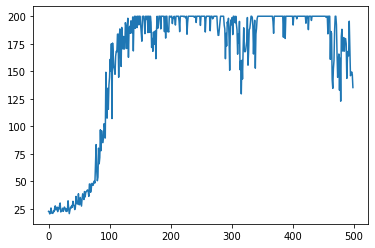

In [ ]:
plt.plot(mean_reward_total)
plt.show()

## **Problem 2**: Pong-v0
Train a neural net that uses images of the game as state and models the policy. The discount factor is 0.99. Use frames of the game as input to a neural net which models the policy. The game has six actions [NOOP, FIRE, RIGHT, LEFT, RIGHTFIRE, LEFTFIRE], but you should train a network that chooses the best action only between [RIGHT, LEFT] (actions 2 and 3). You need to pre-process all the images from the game with following function before feeding them into the
neural network.

In [17]:
env = gym.make("Pong-v0")

# Environment hyperparameters
state_size = [80,80,4]
stack_size = 4
action_size = 2
possible_actions = np.identity(action_size,dtype=int).tolist()

# Training hyperparameters
learning_rate = 0.002
num_epochs = 500
batch_size = 3

training = True

In [18]:
def preprocess(image):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 2D float array """
    image = image[35:195] # crop
    image = image[::2,::2,0] # downsample by factor of 2
    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else (paddles, ball) just set to 1
    return np.reshape(image.astype(np.float).ravel(), [80,80])

In [19]:
stacked_frames = deque([np.zeros((80,80), dtype = np.float32) for i in range(stack_size)], maxlen = stack_size)
def stack_frames(stacked_frames, state, is_new_episode):
    frame = preprocess(state)

    if is_new_episode:
        stacked_frames = deque([np.zeros((80,80), dtype = np.float32) for i in range(stack_size)], maxlen = stack_size)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        # stack the frames
        stacked_states = np.stack(stacked_frames, axis=2)

    else:
        stacked_frames.append(frame)
        stacked_states = np.stack(stacked_frames, axis=2)

    return stacked_states, stacked_frames

    



In [20]:
class PGNetwork2:
    def __init__(self, state_size, action_size, learning_rate, name = "PGNetwork2"):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate

        with tf.variable_scope(name):
            with tf.name_scope("inputs"):
                self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name = "inputs_")
                self.actions = tf.placeholder(tf.int32, [None, action_size], name = "actions")
                self.discounted_reward_delta = tf.placeholder(tf.float32, [None, ], name = "discounted_reward_delta")

            with tf.name_scope("conv1"):
                self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                              filters = 32,
                                              kernel_size = [8,8],
                                              strides = [4,4],
                                              padding = "VALID",
                                              kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                              name = "conv1")
                self.conv1_batchnorm = tf.layers.batch_normalization(self.conv1,
                                                                    training = True,
                                                                    epsilon = 1e-5,
                                                                    name = "batch_norm1")
                self.conv1_out = tf.nn.relu(self.conv1_batchnorm, name = "conv1_out")

            with tf.name_scope("conv2"):
                self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                              filters = 64,
                                              kernel_size = [4,4],
                                              strides = [2,2],
                                              padding = "VALID",
                                              kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                              name = "conv2")
                self.conv2_batchnorm = tf.layers.batch_normalization(self.conv2,
                                                                    training = True,
                                                                    epsilon = 1e-5,
                                                                    name = "batch_norm2")
                self.conv2_out = tf.nn.relu(self.conv2_batchnorm, name = "conv2_out")

            with tf.name_scope("conv3"):
                self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                              filters = 64,
                                              kernel_size = [3,3],
                                              strides = [1,1],
                                              padding = "VALID",
                                              kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                              name = "conv3")
                self.conv3_batchnorm = tf.layers.batch_normalization(self.conv3,
                                                                    training = True,
                                                                    epsilon = 1e-5,
                                                                    name = "batch_norm3")
                self.conv3_out = tf.nn.relu(self.conv3_batchnorm, name = "conv3_out")

            with tf.name_scope("flatten"):
                self.flatten = tf.contrib.layers.flatten(self.conv3_out)

            with tf.name_scope("fc1"):
                self.fc = tf.layers.dense(inputs = self.flatten,
                                          units = 512,
                                          activation = tf.nn.relu,
                                          kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                          name = "fc1")

            with tf.name_scope("logits"):
                self.logits = tf.layers.dense(inputs = self.fc,
                                          units = action_size,
                                          activation = None,
                                          kernel_initializer = tf.contrib.layers.xavier_initializer())

            with tf.name_scope("softmax"):
                self.action_distribution = tf.nn.softmax(self.logits)

            with tf.name_scope("loss"):
                self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.actions)
                self.weighted_negative_likelihoods = tf.multiply(self.cross_entropy, self.discounted_reward_delta)
                self.loss = tf.reduce_mean(self.weighted_negative_likelihoods)

            with tf.name_scope("train"):
                self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
                self.train_opt = self.optimizer.minimize(self.loss)







In [21]:
class ValueEstimator2:
    def __init__(self, state_size, learning_rate, name = "ValueEstimator2"):
        self.state_size = state_size
        self.learning_rate = learning_rate

        with tf.variable_scope(name):
            with tf.name_scope("inputs"):
                self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name = "inputs_")
                self.discounted_episode_rewards_ = tf.placeholder(tf.float32, [None, ], name = "discounted_episode_rewards_")

            with tf.name_scope("conv1"):
                self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                              filters = 32,
                                              kernel_size = [8,8],
                                              strides = [4,4],
                                              padding = "VALID",
                                              kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                              name = "conv1")
                self.conv1_batchnorm = tf.layers.batch_normalization(self.conv1,
                                                                    training = True,
                                                                    epsilon = 1e-5,
                                                                    name = "batch_norm1")
                self.conv1_out = tf.nn.relu(self.conv1_batchnorm, name = "conv1_out")

            with tf.name_scope("conv2"):
                self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                              filters = 64,
                                              kernel_size = [4,4],
                                              strides = [2,2],
                                              padding = "VALID",
                                              kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                              name = "conv2")
                self.conv2_batchnorm = tf.layers.batch_normalization(self.conv2,
                                                                    training = True,
                                                                    epsilon = 1e-5,
                                                                    name = "batch_norm2")
                self.conv2_out = tf.nn.relu(self.conv2_batchnorm, name = "conv2_out")

            with tf.name_scope("conv3"):
                self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                              filters = 64,
                                              kernel_size = [3,3],
                                              strides = [1,1],
                                              padding = "VALID",
                                              kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                              name = "conv3")
                self.conv3_batchnorm = tf.layers.batch_normalization(self.conv3,
                                                                    training = True,
                                                                    epsilon = 1e-5,
                                                                    name = "batch_norm3")
                self.conv3_out = tf.nn.relu(self.conv3_batchnorm, name = "conv3_out")

            with tf.name_scope("flatten"):
                self.flatten = tf.contrib.layers.flatten(self.conv3_out)

            with tf.name_scope("fc1"):
                self.fc = tf.layers.dense(inputs = self.flatten,
                                          units = 512,
                                          activation = tf.nn.relu,
                                          kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                          name = "fc1")
            with tf.name_scope("fc2"):
                self.fc2 = tf.layers.dense(inputs = self.fc,
                                          units = 1,
                                          activation = None,
                                          kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                          name = "fc2")

            with tf.name_scope("output"):
                self.state_value_estimation = tf.squeeze(self.fc2)

            with tf.name_scope("loss"):
                self.loss = tf.reduce_mean(tf.squared_difference(self.state_value_estimation, self.discounted_episode_rewards_))

            with tf.name_scope("train"):
                self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
                self.train_opt = self.optimizer.minimize(self.loss)

In [22]:
def make_batch2(batch_size, stacked_frames):
    states, episode_states, actions, rewards_of_episode, rewards_of_batch, discounted_rewards, discounted_reward_delta = [],[],[],[],[],[],[]

    episode_num = 1

    state = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, state, True)


    while True:
        action_probability_distribution = sess.run(PGNetwork2.action_distribution, feed_dict = {PGNetwork2.inputs_:state.reshape(1, *state_size)})

        action = np.random.choice(range(2), p = action_probability_distribution.ravel())
        next_step, reward, done, info = env.step(action+2)

        states.append(state)
        episode_states.append(state)
        action_ = [1 if i==action else 0 for i in range(action_size)]
        actions.append(action_)
        rewards_of_episode.append(reward)


        if done:
            discounted_rewards_of_episode = discount_rewards(rewards_of_episode, gamma = 0.99, normalization = True)
            rewards_of_batch.append(rewards_of_episode)
            discounted_rewards.append(discounted_rewards_of_episode)

            value_est = sess.run(ValueEstimator2.state_value_estimation, feed_dict={ValueEstimator2.inputs_:np.stack(episode_states).reshape((len(episode_states), *state_size))})
            discounted_reward_delta.append(discounted_rewards_of_episode - value_est)


            if episode_num == batch_size:
                break

            rewards_of_episode = []
            episode_states = []
            episode_num += 1

            state = env.reset()
            state, stacked_frames = stack_frames(stacked_frames, state, True)

        else:
            next_step, stacked_frames = stack_frames(stacked_frames, next_step, False)
            state = next_step

    return np.stack(np.array(states)), np.stack(np.array(actions)), np.concatenate(rewards_of_batch), np.concatenate(discounted_rewards), np.concatenate(discounted_reward_delta)

In [23]:
tf.reset_default_graph()
PGNetwork2 = PGNetwork2(state_size, action_size, learning_rate)
ValueEstimator2 = ValueEstimator2(state_size, learning_rate)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [ ]:
epoch = 1
mean_reward_total = []

if training:
    while epoch < num_epochs + 1:
        states_mb, actions_mb, rewards_of_batch, discounted_rewards_mb, discounted_reward_delta_mb = make_batch2(batch_size, stacked_frames)
        mean_reward_of_that_batch = np.divide(np.sum(rewards_of_batch), batch_size)
        mean_reward_total.append(mean_reward_of_that_batch)

        print("=======================================================")
        print("Epoch: ", epoch, "/", num_epochs)
        print("---------------")
        print("Number of training episodes: {}".format(nb_episodes_mb))
        print("Mean reward of the batch: {}".format(mean_reward_of_that_batch))

        sess.run([ValueEstimator2.loss, ValueEstimator2.train_opt], feed_dict={ValueEstimator2.inputs_: states_mb.reshape((len(states_mb),*state_size)), ValueEstimator2.discounted_episode_rewards_: discounted_rewards_mb})
        sess.run([PGNetwork2.loss, PGNetwork2.cross_entropy, PGNetwork2.train_opt], feed_dict = {PGNetwork2.inputs_: states_mb.reshape((len(states_mb),*state_size)), PGNetwork2.actions: actions_mb, PGNetwork2.discounted_reward_delta: discounted_reward_delta_mb})

        epoch += 1

Epoch:  1 / 500
---------------
Number of training episodes: 3
Mean reward of the batch: -21.0
Epoch:  2 / 500
---------------
Number of training episodes: 3
Mean reward of the batch: -21.0
Epoch:  3 / 500
---------------
Number of training episodes: 3
Mean reward of the batch: -21.0
Epoch:  4 / 500
---------------
Number of training episodes: 3
Mean reward of the batch: -21.0
Epoch:  5 / 500
---------------
Number of training episodes: 3
Mean reward of the batch: -20.666666666666668
Epoch:  6 / 500
---------------
Number of training episodes: 3
Mean reward of the batch: -20.666666666666668
Epoch:  7 / 500
---------------
Number of training episodes: 3
Mean reward of the batch: -21.0
Epoch:  8 / 500
---------------
Number of training episodes: 3
Mean reward of the batch: -21.0
Epoch:  9 / 500
---------------
Number of training episodes: 3
Mean reward of the batch: -20.333333333333332
Epoch:  10 / 500
---------------
Number of training episodes: 3
Mean reward of the batch: -21.0
Epoch: 

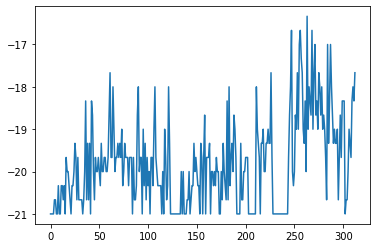

In [3]:
plt.plot(mean_reward_total)
plt.show()